In [2]:
import torch
import torch.nn.utils as nn_utils
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

#import mkdirs
import os
import cv2
import numpy as np
# from pytorch_fid import fid_score
from torchvision.models import inception_v3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define generator and discriminator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn_utils.weight_norm(nn.Linear(latent_dim, 128)),
            nn.ReLU(),
            nn_utils.weight_norm(nn.Linear(128, img_dim)),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn_utils.weight_norm(nn.Linear(img_dim, 256)), # Increased from 128 to 256
            nn.ReLU(),
            nn_utils.weight_norm(nn.Linear(256, 256)), # Added an extra layer
            nn.ReLU(),
            nn_utils.weight_norm(nn.Linear(256, 1)),
        )

    def forward(self, x):
        return self.disc(x)
def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [6]:
# Define the file path to store the results
data_path = '/content/drive/MyDrive/AIP_Course_project/Exes/WGAN_Base/'

In [7]:
#create folder to save generated images
os.makedirs(data_path, exist_ok=True)

In [8]:
# Hyperparameters
lr = 0.00005
batch_size = 64
latent_dim = 128
img_dim = 28 * 28
epochs = 300
lmbda = 10
gradient_clip_value = 0.1

# Data Loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
dataset = datasets.MNIST("data", transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim, img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)
generator.apply(init_weights)
discriminator.apply(init_weights)

100%|██████████| 9912422/9912422 [00:00<00:00, 96558357.28it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23331219.92it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 59872663.81it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21096931.08it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [9]:

def plot_images(real_imgs, fake_imgs, epoch):
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    
    for i in range(5):
        axs[0, i].imshow(real_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].imshow(fake_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axs[1, i].axis('off')

    plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    img_dir = data_path
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    plt.savefig(f"{img_dir}/epoch_{epoch}.png")
    plt.close(fig)

def plot_loss(Y1,Y2):
    
    # print(Y2.type())
    X = np.linspace(0, 93800, 469000)
    # Plot Y1 vs X and Y2 vs X on the same plot
    plt.plot(X, Y1, label='Critic Loss')
    X = np.linspace(0, 93800, 93800)
    plt.plot(X, Y2, label='Generator Loss')

    # Add labels and legend to the plot
    plt.xlabel('No.iterations')
    plt.ylabel('Loss')
    plt.title('Generator and Discrimainator Loss plot')
    plt.legend()
    # Display the plot
    plt.show()

In [ ]:
loss1 = []
loss2 = []
discriminator_iters=5
import math
FID_Sccore=[]
# Training loop
for epoch in range(epochs):
        for batch_idx, (real_imgs, _) in enumerate(dataloader):
            realimgsfid=real_imgs
            real_imgs = real_imgs.view(-1, img_dim).to(device)
            batch_size = real_imgs.shape[0]
            # Train Discriminator
            for _ in range(discriminator_iters):
                optimizer_D.zero_grad()
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = generator(z)
                D_real = discriminator(real_imgs)
                D_fake = discriminator(fake_imgs)
                #print(D_real.shape, D_fake.shape)
                real_imgs.requires_grad = True
                alpha = torch.rand(batch_size, 1).to(device)
                interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True).to(device)
                D_interpolates = discriminator(interpolates)
                fake_gradients = torch.autograd.grad(outputs=D_interpolates, inputs=interpolates,
                                                    grad_outputs=torch.ones_like(D_interpolates),
                                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
                gradient_v1 = ((fake_gradients.norm(2, dim=1) - 1) ** 2).mean()
                #gradient_penalty=0
                #gradient_penalty = ((discriminator(real_imgs) - D_real).pow(2).sum(1).sqrt() - 1).pow(2).mean()
                #print(f"Epoch [{epoch + 1}/{epochs}] Batch {batch_idx}/{len(dataloader)} Gradient Penalty: {gradient_penalty.item():.4f}")
                real_imgs.requires_grad = False          
                loss_D = -(torch.mean(D_real) - torch.mean(D_fake) - lmbda * gradient_v1)
                loss1.append(loss_D.cpu().detach().numpy())
                #print(f"Epoch [{epoch + 1}/{epochs}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_D.item():.4f}")
                loss_D.backward()
                nn.utils.clip_grad_norm_(discriminator.parameters(), gradient_clip_value)
                optimizer_D.step()
            # Train Generator
            if batch_idx % 1 == 0:
                optimizer_G.zero_grad()
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = generator(z)
                D_fake = discriminator(fake_imgs)
                loss_G = -torch.mean(D_fake)
                loss2.append(loss_G.cpu().detach().numpy())
                loss_G.backward()
                #nn.utils.clip_grad_norm_(generator.parameters(), gradient_clip_value)
                optimizer_G.step()  
        print(f"Epoch [{epoch + 1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
        #visualize_generated_images(epoch + 1, generator, latent_dim, img_dim, device)
        with torch.no_grad():
                z = torch.randn(5, latent_dim).to(device)
                fake_imgs = generator(z)
                plot_images(real_imgs[:9], fake_imgs, epoch + 1)
        
        

#save model
torch.save(generator.state_dict(), '/content/drive/MyDrive/generator100.pth')
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/discriminator100.pth')



Epoch [1/300] Loss D: -10.3308, Loss G: -11.4083
Epoch [2/300] Loss D: -8.1712, Loss G: -7.2371
Epoch [3/300] Loss D: -6.0987, Loss G: -7.2905
Epoch [4/300] Loss D: -5.2225, Loss G: -8.4794
Epoch [5/300] Loss D: -4.6784, Loss G: -7.8706
Epoch [6/300] Loss D: -4.0373, Loss G: -8.9758
Epoch [7/300] Loss D: -4.0235, Loss G: -8.0638
Epoch [8/300] Loss D: -4.0820, Loss G: -8.7102
Epoch [9/300] Loss D: -4.1405, Loss G: -7.8567
Epoch [10/300] Loss D: -3.8915, Loss G: -5.5677
Epoch [11/300] Loss D: -3.4987, Loss G: -5.7782
Epoch [12/300] Loss D: -4.4174, Loss G: -3.8608
Epoch [13/300] Loss D: -4.7863, Loss G: -4.3762
Epoch [14/300] Loss D: -4.4385, Loss G: -4.1581
Epoch [15/300] Loss D: -3.8996, Loss G: -3.5273
Epoch [16/300] Loss D: -4.5733, Loss G: -2.8810
Epoch [17/300] Loss D: -5.4014, Loss G: -2.3631
Epoch [18/300] Loss D: -5.0190, Loss G: -2.2893
Epoch [19/300] Loss D: -4.1703, Loss G: -2.7385
Epoch [20/300] Loss D: -4.7392, Loss G: -1.6317
Epoch [21/300] Loss D: -5.2997, Loss G: -1.3890

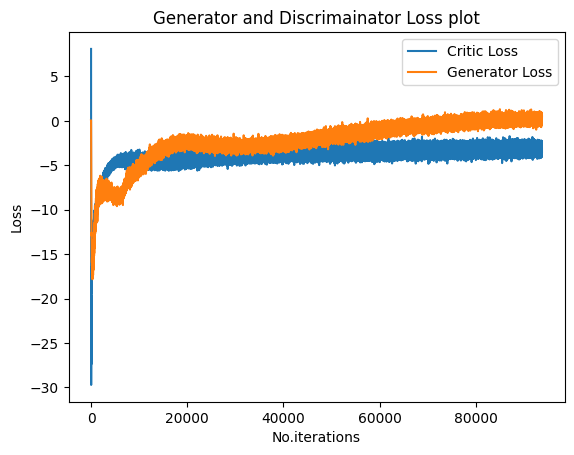

In [34]:
plot_loss(loss1,loss2)

In [26]:
print(len(loss1))

469000
